### Notebook to examine USGS streamflow data for the Mississippi River. 
We want to get a simple sine wave approximation to the river temperature and apply it to the streamflow data within MPAS-O. 

### The sine wave takes the form 
$A * \sin(w*t + p) + c$

In [1]:
# first import the functions for downloading data from NWIS
import dataretrieval.nwis as nwis
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np, scipy.optimize

In [3]:
nwis.get_record?

Signature:
nwis.get_record(
    sites=None,
    start=None,
    end=None,
    multi_index=True,
    wide_format=True,
    datetime_index=True,
    state=None,
    service='iv',
    ssl_check=True,
    **kwargs,
)
Docstring:
Get data from NWIS and return it as a ``pandas.DataFrame``.

.. note::

    If no start or end date are provided, only the most recent record is
    returned.

Parameters
----------
sites: list-like
    List or comma delimited string of site.
start: string
    Starting date of record (YYYY-MM-DD)
end: string
    Ending date of record. (YYYY-MM-DD)
service: string
    - 'iv' : instantaneous data
    - 'dv' : daily mean data
    - 'qwdata' : discrete samples
    - 'site' : site description
    - 'measurements' : discharge measurements
    - 'peaks': discharge peaks
    - 'gwlevels': groundwater levels
    - 'pmcodes': get parameter codes
    - 'water_use': get water use data
    - 'ratings': get rating table
    - 'stat': get statistics
ssl_check: bool
    If True, ch

### The data are available at https://waterdata.usgs.gov/monitoring-location/07374000/#parameterCode=00010&showMedian=false&period=P30D.
The available data goes from October 2007-present

In [4]:
# specify the USGS site code for which we want data.
site = '07374000' # Mississippi River at Baton Rouge, LA

# get instantaneous values (iv)
df = nwis.get_record(sites=site, service='dv', start='2007-10-01', end='2024-03-01')

# get basic info about the site
df1 = nwis.get_record(sites=site, service='site')

In [5]:
df.head()

,00010_Maximum,00010_Maximum_cd,site_no,00010_Minimum,00010_Minimum_cd,00010_Mean,00010_Mean_cd,00060_Mean,00060_Mean_cd,00065_Maximum,...,00480_Mean,00480_Mean_cd,63680_Maximum,63680_Maximum_cd,63680_Minimum,63680_Minimum_cd,63680_Mean,63680_Mean_cd,99133_Mean,99133_Mean_cd
datetime,,,,,,,,,,,,,,,,,,,,,
2007-10-01 00:00:00+00:00,26.4,A,07374000,25.9,A,26.1,A,210000.0,A,6.69,...,0.3,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-10-02 00:00:00+00:00,26.4,A,07374000,25.8,A,26.1,A,202000.0,A,6.33,...,0.3,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-10-03 00:00:00+00:00,26.5,A,07374000,25.9,A,26.1,A,200000.0,A,6.31,...,0.3,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-10-04 00:00:00+00:00,26.4,A,07374000,26.0,A,26.1,A,201000.0,A,6.35,...,0.3,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-10-05 00:00:00+00:00,26.3,A,07374000,26.0,A,26.1,A,203000.0,A,6.34,...,0.3,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df1.head()

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,local_time_fg,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no
0,USGS,07374000,"Mississippi River at Baton Rouge, LA",ST,302644.4,911129.6,30.445667,-91.191556,M,S,...,Y,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,BBB00


### From the website, ```00010``` is the tag for temperature. Since we are looking at daily mean values, we have the ```_Mean``` suffix added 

Text(0.5, 1.0, 'Mississippi River temperature at Baton Rouge')

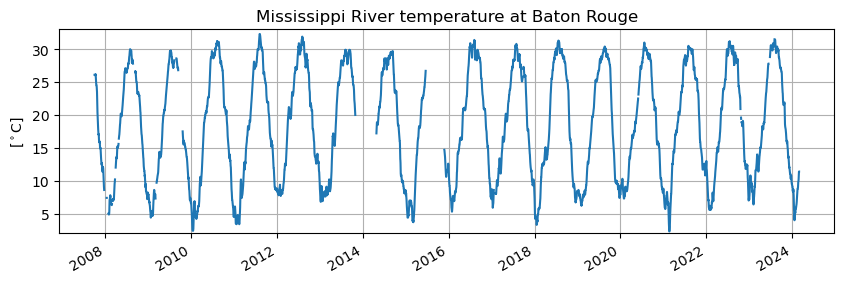

In [7]:
fig, ax = plt.subplots(1, figsize = (10,3), dpi = 100)

df['00010_Mean'].plot()
plt.ylim(2,33)
plt.grid(which = 'both')
plt.xlabel('')
plt.ylabel(r'[$^\circ$C]')
plt.title('Mississippi River temperature at Baton Rouge')

### Now we want to fill the NaNs in the dataset 

In [8]:
df1 = df.interpolate()

Text(0.5, 1.0, 'Mississippi River temperature at Baton Rouge')

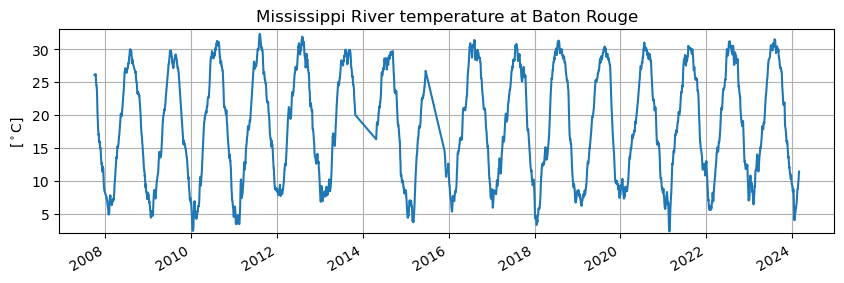

In [9]:
fig, ax = plt.subplots(1, figsize = (10,3), dpi = 100)

df1['00010_Mean'].plot()
plt.ylim(2,33)
plt.grid(which = 'both')
plt.xlabel('')
plt.ylabel(r'[$^\circ$C]')
plt.title('Mississippi River temperature at Baton Rouge')

### Choose from 2016-2024

In [10]:
df1['00010_Mean'][3014:5920]

datetime
2016-01-01 00:00:00+00:00    11.4
2016-01-02 00:00:00+00:00    10.9
2016-01-03 00:00:00+00:00    10.5
2016-01-04 00:00:00+00:00    10.3
2016-01-05 00:00:00+00:00     9.9
                             ... 
2023-12-28 00:00:00+00:00     9.9
2023-12-29 00:00:00+00:00     9.6
2023-12-30 00:00:00+00:00     9.5
2023-12-31 00:00:00+00:00     9.5
2024-01-01 00:00:00+00:00     9.4
Name: 00010_Mean, Length: 2906, dtype: float64

Text(0.5, 1.0, 'Mississippi River temperature at Baton Rouge')

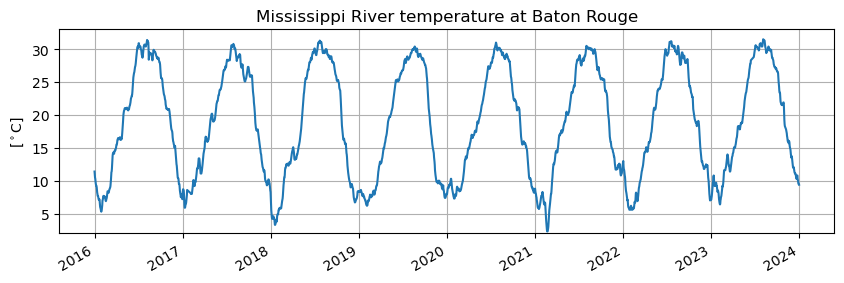

In [11]:
fig, ax = plt.subplots(1, figsize = (10,3), dpi = 100)

df1['00010_Mean'][3014:5920].plot()
plt.ylim(2,33)
plt.grid(which = 'both')
plt.xlabel('')
plt.ylabel(r'[$^\circ$C]')
plt.title('Mississippi River temperature at Baton Rouge')

### Let's fit a sine wave to these values 

In [12]:
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

In [13]:
X = np.arange(0,len(df1.loc['2016-01-01':'2024-01-01']))
Y = df1['00010_Mean'][3014:5920]
res = fit_sin(X, Y)
print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res )

Amplitude=-11.596988148341456, Angular freq.=0.017232731613794402, phase=1.0298528004307235, offset=18.782434595883355, Max. Cov.=0.0018356871755545426


In [15]:
df1['00010_Mean'][3014:5920]

datetime
2016-01-01 00:00:00+00:00    11.4
2016-01-02 00:00:00+00:00    10.9
2016-01-03 00:00:00+00:00    10.5
2016-01-04 00:00:00+00:00    10.3
2016-01-05 00:00:00+00:00     9.9
                             ... 
2023-12-28 00:00:00+00:00     9.9
2023-12-29 00:00:00+00:00     9.6
2023-12-30 00:00:00+00:00     9.5
2023-12-31 00:00:00+00:00     9.5
2024-01-01 00:00:00+00:00     9.4
Name: 00010_Mean, Length: 2906, dtype: float64

In [16]:
time = pd.date_range('2016-01-01','2024-01-01',freq='D')
time

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2023-12-23', '2023-12-24', '2023-12-25', '2023-12-26',
               '2023-12-27', '2023-12-28', '2023-12-29', '2023-12-30',
               '2023-12-31', '2024-01-01'],
              dtype='datetime64[ns]', length=2923, freq='D')

### Why are the lengths inconsistent?

In [17]:
df1['00010_Mean'][3014:5920].isnull().values.any()

False

### There's no NaNs. Maybe duplicate values. 
Just ignore this and create the time vector from scratch in the future.

In [18]:
idx = pd.date_range('2016-01-01','2024-01-01', freq="d")
ts = pd.Series(range(len(idx)), index=idx)
ts

2016-01-01       0
2016-01-02       1
2016-01-03       2
2016-01-04       3
2016-01-05       4
              ... 
2023-12-28    2918
2023-12-29    2919
2023-12-30    2920
2023-12-31    2921
2024-01-01    2922
Freq: D, Length: 2923, dtype: int64

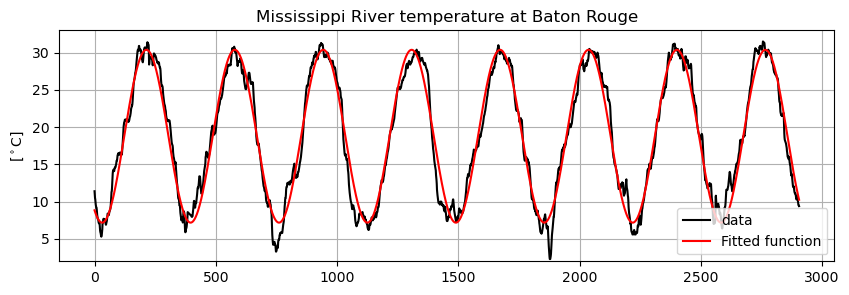

In [19]:
fig, ax = plt.subplots(1, figsize = (10,3), dpi = 100)

plt.plot(X, Y, "-k", label = 'data')
plt.plot(X, res["fitfunc"](X), "r-", label="Fitted function")
plt.ylim(2,33)
plt.grid(which = 'both')
plt.xlabel('')
plt.ylabel(r'[$^\circ$C]')
plt.title('Mississippi River temperature at Baton Rouge')
plt.legend()
plt.show()

### Now let's construct this function ranging from Jan 1, 1958 to Dec 31, 2019 corresponding to JRA forcing 

In [20]:
time = pd.date_range('1958-01-01','2020-01-01', freq="d")

A = -11.596988148341456
w = 0.017232731613794402
p = 1.0298528004307235
c = 18.782434595883355
t = np.arange(0,len(time))
sinwave = A * np.sin(w*t+p) + c

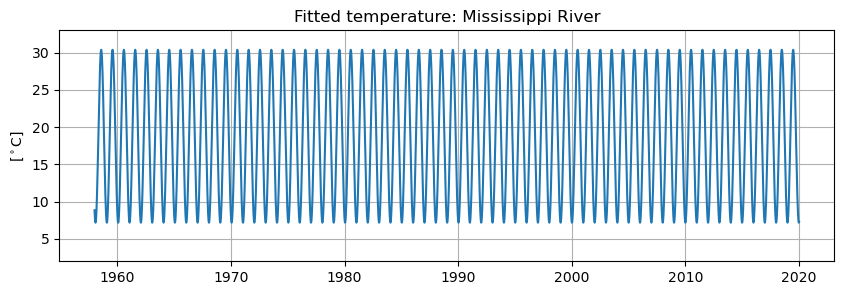

In [25]:
fig, ax = plt.subplots(1, figsize = (10,3), dpi = 100)

plt.plot(time, sinwave)
plt.ylim(2,33)
plt.grid(which = 'both')
plt.xlabel('')
plt.ylabel(r'[$^\circ$C]')
plt.title('Fitted temperature: Mississippi River')
# plt.legend()
plt.show()

### Zoom in just to double check 

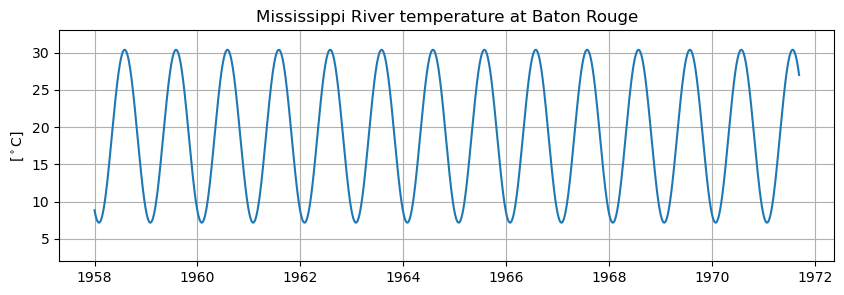

In [22]:
fig, ax = plt.subplots(1, figsize = (10,3), dpi = 100)

plt.plot(time[:5000], sinwave[:5000])
plt.ylim(2,33)
plt.grid(which = 'both')
plt.xlabel('')
plt.ylabel(r'[$^\circ$C]')
plt.title('Mississippi River temperature at Baton Rouge')
plt.show()

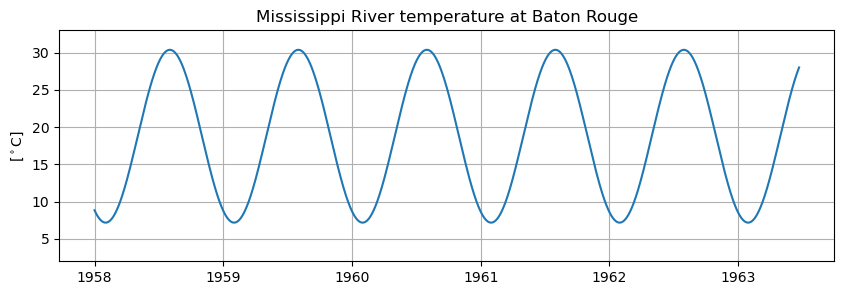

In [23]:
fig, ax = plt.subplots(1, figsize = (10,3), dpi = 100)

plt.plot(time[:2000], sinwave[:2000])
plt.ylim(2,33)
plt.grid(which = 'both')
plt.xlabel('')
plt.ylabel(r'[$^\circ$C]')
plt.title('Mississippi River temperature at Baton Rouge')
plt.show()

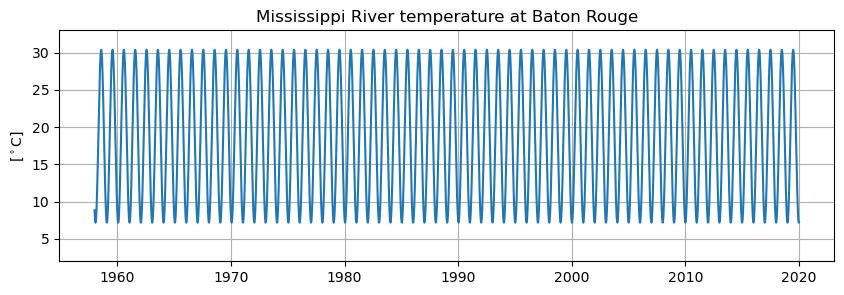

In [24]:
fig, ax = plt.subplots(1, figsize = (10,3), dpi = 100)

plt.plot(time, sinwave)
plt.ylim(2,33)
plt.grid(which = 'both')
plt.xlabel('')
plt.ylabel(r'[$^\circ$C]')
plt.title('Mississippi River temperature at Baton Rouge')
plt.show()